In [2]:
import nltk
import pandas as pd
from nltk.corpus import names
import random
import matplotlib.pyplot as plt

In [9]:
# Calculate total observations, number of female names, number of male names
female_names = names.words('female.txt')
male_names = names.words('male.txt')
total_observations = len(female_names) + len(male_names)

print(f"Number of Female Names: {len(female_names)}")
print(f"Number of Male Names: {len(male_names)}")
print(f"Total Observations: {total_observations}")

Number of Female Names: 5001
Number of Male Names: 2943
Total Observations: 7944


In [10]:
# Let's take a quick look at the combined dataset
labeled_names = [(name, 'male') for name in male_names] + [(name, 'female') for name in female_names]
print("Header of combined dataset:")
print(labeled_names[:15])

Header of combined dataset:
[('Aamir', 'male'), ('Aaron', 'male'), ('Abbey', 'male'), ('Abbie', 'male'), ('Abbot', 'male'), ('Abbott', 'male'), ('Abby', 'male'), ('Abdel', 'male'), ('Abdul', 'male'), ('Abdulkarim', 'male'), ('Abdullah', 'male'), ('Abe', 'male'), ('Abel', 'male'), ('Abelard', 'male'), ('Abner', 'male')]


It looks like our data is flowing in correctly, so let's go ahead and define the sizes per the project instructions, followed by shuffling the lists in place, with a seed for purposes of reproducibility.

In [26]:
test_size = 500
devtest_size = 500
train_size = len(female_names) + len(male_names) - test_size - devtest_size
labeled_names = [(name, 'male') for name in male_names] + [(name, 'female') for name in female_names]
random.seed(2468)  # Setting seed for reproducibility
random.shuffle(labeled_names)

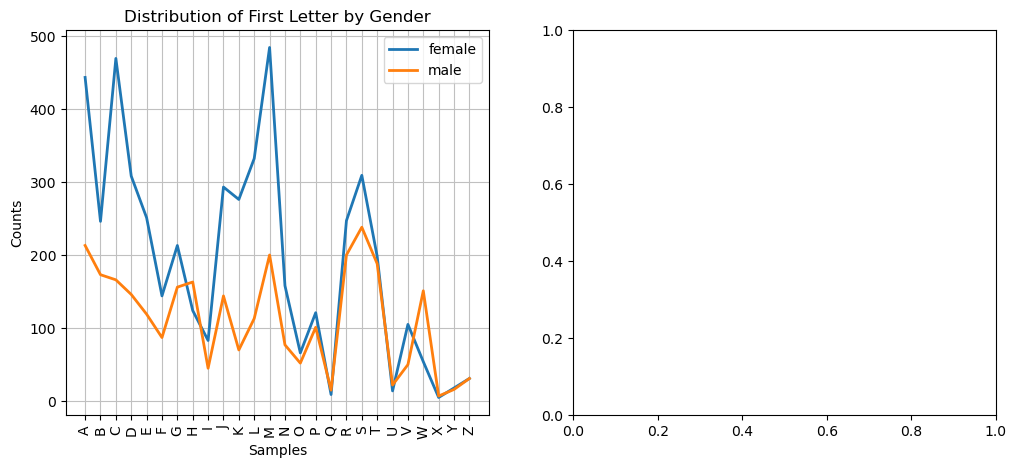

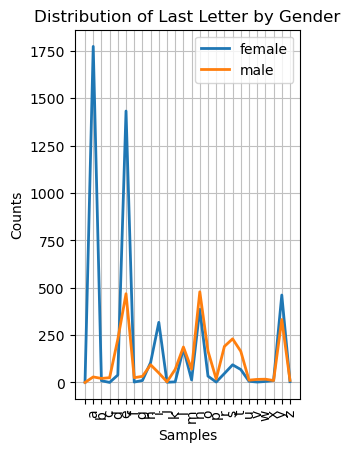

<Figure size 640x480 with 0 Axes>

In [27]:
# Let's now take a look at the distribution of first and last letters conditioned on gender
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
gender_distribution_first = nltk.ConditionalFreqDist((gender, name[0]) for name, gender in labeled_names)
gender_distribution_last = nltk.ConditionalFreqDist((gender, name[-1]) for name, gender in labeled_names)

# Plot for first letter
plt.subplot(1, 2, 1)
gender_distribution_first.plot(title='Distribution of First Letter by Gender')

# Plot for last letter
plt.subplot(1, 2, 2)
gender_distribution_last.plot(title='Distribution of Last Letter by Gender')

plt.tight_layout()
plt.show()


The distribution plot indicates that the first letter of a name could be a good indicator of gender, with certain letters being more common in male or female names. Similarly, the last letter may also provide valuable information for gender classification. We can now select a classifier. We have opted to assess a MaxEnt classifier with multiple training / test splits, shuffling the data for each split, due to the effectiveness of the MaxEnt model's flexibility in handling the complex feature sets that we're tasked with assessing. 

In [29]:
# First we define gender_features, followed by extracting features for the datasets
def gender_features(name):
    return {'last_letter': name[-1]}
test_set = [(gender_features(name), gender) for (name, gender) in test_names]
devtest_set = [(gender_features(name), gender) for (name, gender) in devtest_names]
train_set = [(gender_features(name), gender) for (name, gender) in train_names]

We next need to train our MaxEnt classifier using the training set, evaluate it on the devtest set, and then evaluate it on the test set

In [30]:
MEclassifier = nltk.MaxentClassifier.train(train_set, trace=0)

In [31]:
devtest_accuracy = nltk.classify.accuracy(MEclassifier, devtest_set)
print(f"Devtest Set Accuracy: {devtest_accuracy:.2f}")

Devtest Set Accuracy: 0.75


In [32]:
test_accuracy = nltk.classify.accuracy(MEclassifier, test_set)
print(f"Test Set Accuracy: {test_accuracy:.2f}")

Test Set Accuracy: 0.74


The performance on the test set is just a bit lower than the performance on the dev-test set, indicating that the classifier might be overfitting. To address this, we should consider some feature engineering before re-running the classifier. We've elected to include the last letter the name in the updated MaxEnt classifier. We'll repeast the same steps after re-defining gender_features.

In [33]:
# First and last letters

def gender_features2(name):
    return {'first_letter': name[0].lower(), 'last_letter': name[-1].lower()}
test_set = [(gender_features2(name), gender) for (name, gender) in test_names]
devtest_set = [(gender_features2(name), gender) for (name, gender) in devtest_names]
train_set = [(gender_features2(name), gender) for (name, gender) in train_names]
classifier = nltk.MaxentClassifier.train(train_set, trace=0)
devtest_accuracy = nltk.classify.accuracy(classifier, devtest_set)
print(f"New Devtest Set Accuracy: {devtest_accuracy:.2f}")
test_accuracy = nltk.classify.accuracy(classifier, test_set)
print(f"New Test Set Accuracy: {test_accuracy:.2f}")

Devtest Set Accuracy: 0.76
Test Set Accuracy: 0.76


The model's performance on both the dev-test set and the test set has improved slightly compared to the previous run. The devtest set accuracy is now 76%, and the test set accuracy is also 76%. We can thus infer that the model generalizes adequately to to unseen data, as the performance on the test set is consistent with the performance on the dev-test set. This largely meets our expectations, as the model is not overfitting to the dev-test set. The model, considering both first and last letters of each name as features, gained a bit of power. In general, the improvement demonstrates the incremental effectiveness of feature engineering. We can also take heart in our classifier's consistent performance across datasets